## TimesFM

TimesFM (Time Series Foundation Model) is a pretrained time-series foundation model developed by Google Research for time-series forecasting.

- [Google Research Blog](https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/)
- [GitHub repo](https://github.com/google-research/timesfm)
- [HuggingFace Model Card](https://huggingface.co/google/timesfm-1.0-200m)

## Setup

In [54]:
import os, shutil
from IPython.display import Markdown

In [55]:
DIR = 'temp/timesfm'

In [56]:
if not os.path.exists(DIR):
    os.makedirs(DIR)
else:
    shutil.rmtree(DIR)
!git clone https://github.com/google-research/timesfm.git $DIR

Cloning into 'temp/timesfm'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 121 (delta 55), reused 102 (delta 46), pack-reused 1
Receiving objects: 100% (121/121), 547.21 KiB | 5.11 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [58]:
with open(f'{DIR}/environment_cpu.yml', 'r') as f:
    data = f.read()
Markdown(f"```yaml\n\n{data}\n```")

```yaml

name: tfm_env

channels:
  - conda-forge
  - defaults
  - anaconda
dependencies:
  - jupyterlab
  - pip
  - python=3.10
  - pip:
    - huggingface_hub[cli]
    - utilsforecast
    - praxis
    - paxml
    - jax[cpu]==0.4.26
    - einshape

```

TimesFM comes with Conda Environment files.  Vertex AI Workbench uses Conda Environments - [reference](https://cloud.google.com/vertex-ai/docs/workbench/instances/add-environment).


Conda: Create and Activate the Environment and install `timesfm` from local:
- Open A Terminal: File > New > Terminal
- In the terminal run:
    - `conda env create --file=temp/timesfm/environment_cpu.yml`
    - `conda env list`
    - `conda activate tfm_env`
    - `which pip`
    - `pip install -e temp/timesfm`
    
Add A Kernel For the new Environment:
- `DL_ANACONDA_ENV_HOME="${DL_ANACONDA_HOME}/envs/tfm_env"`
- `python -m ipykernel install --prefix "${DL_ANACONDA_ENV_HOME}" --name tfm_env --display-name TimesFM`

Change Kernel:
- Kernel > Change Kernel
- Select Kernel > Pick TimesFM > Select

Verify The Kernel is `TimeFM` in the upper right:

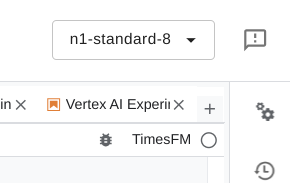

In [1]:
!conda info


     active environment : tfm_env
    active env location : /opt/conda/envs/tfm_env
            shell level : 3
       user config file : /home/jupyter/.condarc
 populated config files : /opt/conda/.condarc
          conda version : 24.1.2
    conda-build version : not installed
         python version : 3.10.14.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=haswell
                          __conda=24.1.2=0
                          __glibc=2.31=0
                          __linux=5.10.0=0
                          __unix=0=0
       base environment : /opt/conda  (writable)
      conda av data dir : /opt/conda/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
        

In [2]:
!which pip

/opt/conda/envs/tfm_env/bin/pip


In [6]:
#!pip install -e temp/timesfm

In [3]:
#!pip install bigframes -q -U

---
## Get Started

In [1]:
import timesfm

In [2]:
tfm = timesfm.TimesFm(
    context_len=32, # multiple of 32 (input_path_len) up to 512
    horizon_len=14, # anything but < context_len recommended
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # cpu or gpu or tpu
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.79 seconds.
Restoring checkpoint from /home/jupyter/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.52 seconds.
Jitting decoding.
Jitted decoding in 28.45 seconds.


In [3]:
import numpy as np

In [4]:
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),
    np.sin(np.linspace(0, 20, 200)),
    np.sin(np.linspace(0, 20, 400)),
]
#forecast_input

In [5]:
frequency_input = [0, 1, 2]
frequency_input

[0, 1, 2]

In [6]:
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=frequency_input,
)
point_forecast

array([[ 0.9295389 ,  0.9578312 ,  0.9545266 ,  0.8985594 ,  0.8552065 ,
         0.73434806,  0.58431673,  0.3920936 ,  0.20289218, -0.00673276,
        -0.25730416, -0.45626634, -0.63850623, -0.8001216 ],
       [ 0.8861648 ,  0.923024  ,  0.9876071 ,  1.023315  ,  1.0321137 ,
         1.0296717 ,  1.0408154 ,  1.0685121 ,  1.0497584 ,  1.0751126 ,
         1.07947   ,  1.0454366 ,  1.0126661 ,  1.0177269 ],
       [ 0.9092182 ,  0.9536099 ,  0.9658944 ,  0.9697123 ,  0.985045  ,
         1.0228808 ,  1.0523278 ,  1.1258184 ,  1.1216611 ,  1.1497967 ,
         1.1614591 ,  1.2049536 ,  1.2251331 ,  1.3108364 ]],
      dtype=float32)

In [7]:
type(tfm._model)

patched_decoder.PatchedTimeSeriesDecoder

In [8]:
type(tfm._train_state)

paxml.train_states.TrainState

## BigQuery With BigFrames

In [38]:
import bigframes.pandas as bpd
import pandas as pd
#bpd.options.bigquery.project = project_id
#bpd.options.bigquery.location = 'us'

In [13]:
ds = bpd.read_gbq(
"""
SELECT
    start_station_name,
    COUNT(*) as num_trips,
    EXTRACT(DATE FROM starttime) AS starttime
FROM bigquery-public-data.new_york.citibike_trips
WHERE start_station_name LIKE '%Central Park%'
GROUP BY start_station_name, starttime
"""
)

In [14]:
ds.head()

,start_station_name,num_trips,starttime
0,Grand Army Plaza & Central Park S,190,2014-09-11
1,Grand Army Plaza & Central Park S,167,2015-07-07
2,Grand Army Plaza & Central Park S,73,2014-10-04
3,Central Park West & W 76 St,135,2016-06-17
4,Grand Army Plaza & Central Park S,259,2016-07-02


In [15]:
local_ds = ds.to_pandas().sort_values(['start_station_name', 'starttime'])

In [39]:
local_ds.dtypes

start_station_name         string[pyarrow]
num_trips                            Int64
starttime             date32[day][pyarrow]
dtype: object

In [40]:
local_ds['starttime'] = pd.to_datetime(local_ds['starttime'])

In [41]:
local_ds.dtypes

start_station_name    string[pyarrow]
num_trips                       Int64
starttime              datetime64[ns]
dtype: object

start_station_name
Central Park North & Adam Clayton Powell Blvd    Axes(0.125,0.11;0.775x0.77)
Central Park S & 6 Ave                           Axes(0.125,0.11;0.775x0.77)
Central Park W & W 96 St                         Axes(0.125,0.11;0.775x0.77)
Central Park West & W 100 St                     Axes(0.125,0.11;0.775x0.77)
Central Park West & W 102 St                     Axes(0.125,0.11;0.775x0.77)
Central Park West & W 68 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 72 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 76 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 85 St                      Axes(0.125,0.11;0.775x0.77)
Grand Army Plaza & Central Park S                Axes(0.125,0.11;0.775x0.77)
W 106 St & Central Park West                     Axes(0.125,0.11;0.775x0.77)
W 82 St & Central Park West                      Axes(0.125,0.11;0.775x0.77)
Name: num_trips, dtype: object

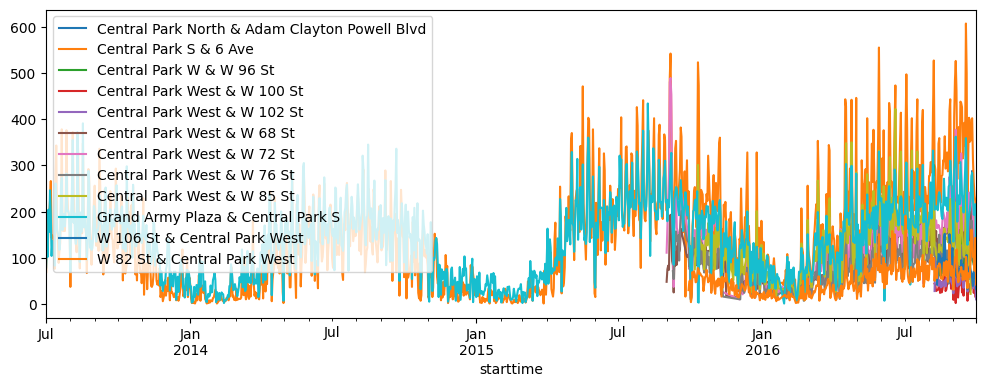

In [42]:
local_ds.set_index('starttime').groupby('start_station_name')['num_trips'].plot(legend = 'True', figsize = (12, 4))

In [44]:
local_ds[local_ds['start_station_name']=='Central Park W & W 96 St'].rename(columns = {'start_station_name':'unique_id', 'starttime':'ds'})

,unique_id,num_trips,ds
2088,Central Park W & W 96 St,85,2016-08-04
3389,Central Park W & W 96 St,135,2016-08-05
230,Central Park W & W 96 St,240,2016-08-06
495,Central Park W & W 96 St,301,2016-08-07
1588,Central Park W & W 96 St,132,2016-08-08
890,Central Park W & W 96 St,69,2016-08-09
1873,Central Park W & W 96 St,63,2016-08-10
217,Central Park W & W 96 St,69,2016-08-11
2410,Central Park W & W 96 St,48,2016-08-12
1850,Central Park W & W 96 St,62,2016-08-13


In [45]:
forecast_ds = tfm.forecast_on_df(
    inputs = local_ds[local_ds['start_station_name']=='Central Park W & W 96 St'].rename(columns = {'start_station_name':'unique_id', 'starttime':'ds'}),
    freq = "D",
    value_name = 'num_trips',
    num_jobs = 1
)

Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


In [46]:
forecast_ds

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,Central Park W & W 96 St,2016-10-01,115.099258,63.349670,80.597954,93.593910,103.655342,115.099258,124.982727,136.894852,152.119949,174.398453
1,Central Park W & W 96 St,2016-10-02,119.052338,66.030144,84.448219,97.977676,108.881592,119.052338,130.424118,143.095718,158.198593,181.620087
2,Central Park W & W 96 St,2016-10-03,95.216904,47.837955,64.088997,74.079666,85.096817,95.216904,104.928566,115.279991,128.425201,149.493607
3,Central Park W & W 96 St,2016-10-04,92.303307,47.297932,62.567638,72.800377,82.527840,92.303307,102.398941,112.659286,125.589066,145.480438
4,Central Park W & W 96 St,2016-10-05,88.190773,43.517807,58.498363,68.539490,79.071892,88.190773,97.116386,108.236290,120.377983,139.836731
5,Central Park W & W 96 St,2016-10-06,81.188995,38.298767,52.374165,62.903732,72.832291,81.188995,91.343933,100.613083,113.378487,133.038910
6,Central Park W & W 96 St,2016-10-07,90.274788,45.190926,61.168091,72.141136,81.490944,90.274788,100.170143,111.220734,124.614456,145.113892
7,Central Park W & W 96 St,2016-10-08,114.719368,61.439026,79.860428,93.187042,105.030777,114.719368,125.392685,138.059265,152.700592,175.722870
8,Central Park W & W 96 St,2016-10-09,119.069550,64.688499,83.160896,96.897736,108.467354,119.069550,129.317917,142.400955,157.787903,180.617554
9,Central Park W & W 96 St,2016-10-10,94.266098,47.996071,62.871311,75.098923,84.394829,94.266098,104.272781,114.509583,129.086121,150.232864
